In [1]:
%%capture
!pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate
%matplotlib notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 128.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 78.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 109.1

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torchvision.utils import save_image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Creating datasets

In [3]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=3
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=3
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=3
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

torch.Size([3, 256, 256])


<IPython.core.display.Javascript object>

### Autoencoder Setup

In [3]:
autoencoder = AutoencoderKL(in_channels=1,
                            out_channels=1,
                            down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
                            up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
                            block_out_channels=(128,256,512,512),
                            layers_per_block=2,
                            sample_size=256
                            )

pl_ae_model = Autoencoder(autoencoder)


### Autoencoder training

In [ ]:
ae_trainer = pl.Trainer(default_root_dir="trained_models/ae/",
                        max_epochs=400)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5, shuffle=True)

ae_trainer.fit(pl_ae_model, train_dataloaders=train_dl, val_dataloaders=valid_dl)

### Testing autoencoder

In [5]:
# Load checkpoint
pl_ae_model = Autoencoder.load_from_checkpoint('trained_models/ae/lightning_logs/version_5/checkpoints/epoch=92-step=11625.ckpt', autoencoder = autoencoder)
pl_ae_model.to(device)

Autoencoder(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
            (1): ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=

In [4]:
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
pl_ae_model = Autoencoder(autoencoder).to(device)

array([-0.00585252,  0.00635832,  0.00348437, ...,  0.00036422,
       -0.00553351,  0.00156129], dtype=float32)

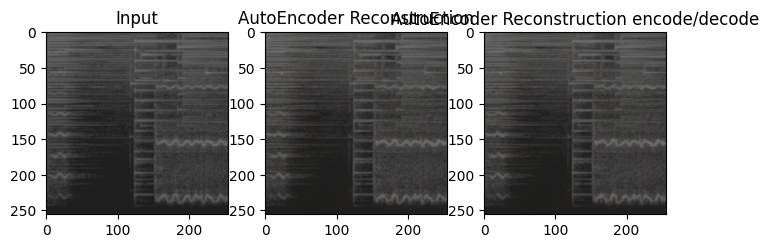

In [5]:
img, cond = test_ds[0]
phase = test_ds.get_phase(0)

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title('Input')
plt.subplot(1,3,2)
prod_img = pl_ae_model(img.unsqueeze(0).to(device))
plt.imshow(prod_img[0].detach().cpu().permute(1,2,0))
plt.title('AutoEncoder Reconstruction')
plt.subplot(1,3,3)
prod_img2 = pl_ae_model.decode(pl_ae_model.encode(img.unsqueeze(0).to(device)))
plt.imshow(prod_img2[0].detach().cpu().permute(1,2,0))
plt.title('AutoEncoder Reconstruction encode/decode')

test_ds.save_audio(img, phase, name='orig_test.wav')
test_ds.save_audio(prod_img.detach().cpu()[0], phase, name='ae_test.wav')

### Model setup

In [5]:
model=LatentDiffusionConditional(train_ds,
                                 autoencoder=pl_ae_model,
                                 valid_dataset=valid_ds,
                                 lr=1e-5,
                                 batch_size=16,
                                 schedule='linear')

Is Time embed used ?  True


### Training

In [6]:
trainer = pl.Trainer(
    default_root_dir="trained_models/latent_diffusion/3_channels_pretrained_ae",
    max_epochs=3000,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

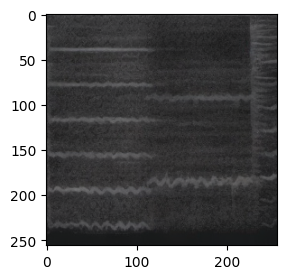

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.fit(model)

### Load checkpoint

In [7]:
trainer.fit(model, ckpt_path='trained_models/latent_diffusion/3_channels_pretrained_ae/lightning_logs/version_12/checkpoints/epoch=1392-step=44576.ckpt')

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at trained_models/latent_diffusion/3_channels_pretrained_ae/lightning_logs/version_12/checkpoints/epoch=1392-step=44576.ckpt


<IPython.core.display.Javascript object>

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | ae    | Autoencoder                          | 83.7 M
1 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
140 M     Trainable params
0         Non-trainable params
140 M     Total params
561.105   Total estimated model params size (MB)
Restored all states from the checkpoint at trained_models/latent_diffusion/3_channels_pretrained_ae/lightning_logs/version_12/checkpoints/epoch=1392-step=44576.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

In [ ]:
model = LatentDiffusionConditional.load_from_checkpoint('trained_models/latent_diffusion/lightning_logs/version_0/checkpoints/epoch=477-step=7648.ckpt',
                                                        train_dataset=train_ds,
                                                        autoencoder=pl_ae_model,
                                                        valid_dataset=valid_ds,
                                                        lr=1e-5,
                                                        batch_size=16,
                                                        schedule='linear')

### Create sample

In [1]:
song_num = 3
condition,target=test_ds[1song_num]
batch_input=torch.stack(4*[condition],0)

#model.cuda()
out=model(batch_input, verbose=True)

NameError: name 'test_ds' is not defined

In [9]:
plt.subplot(1,2+len(out),1)
plt.imshow(condition.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(target.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')
plt.show()


<IPython.core.display.Javascript object>

In [20]:
phase = test_ds.get_phase(song_num)

name = test_ds.files[song_num]
test_ds.save_audio(out[0].detach().cpu(), phase, name = name)
test_ds.save_audio(target, phase, name = 'target_' + name)
test_ds.save_audio(condition, phase, name = 'target_' + name)
save_image(out[0], 'results/produced_' + name.replace('wav','png'))
save_image(condition, 'results/condition_' + name.replace('wav','png'))
save_image(target, 'results/target_' + name.replace('wav','png'))